This notebook focuses on using the UNET Denoiser on a category of the cifar10 data set (airplanes) for reproducing the orignal image from just its noise/phase.

In [0]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.utils import np_utils
#from keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, UpSampling2D, concatenate 
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
import numpy as np

# Load the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
airplanes = []
for counter, value in enumerate(y_train):
    if value != 4:
      airplanes.append(counter)
x_train_airplane1 = np.delete(x_train, airplanes, 0)

airplanes = []
for counter, value in enumerate(y_test):
    if value != 4:
      airplanes.append(counter)
x_test_airplane1 = np.delete(x_test, airplanes, 0)

del x_train
del x_test
del y_train
del y_test
del airplanes

In [0]:
x_train_airplane1 = x_train_airplane1.astype('float32')
x_test_airplane1 = x_test_airplane1.astype('float32')
x_train_airplane1 /= 255.
x_test_airplane1 /= 255.

#print(x_test_airplane[1])
print('Original training data shape: {}'.format(x_train_airplane1.shape))

Original training data shape: (5000, 32, 32, 3)


# UNET MODEL

In [0]:
inputs = Input((32,32,3))

#convolution and pool (downsample) #1
c_0 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
p_0 = MaxPooling2D(pool_size=(2, 2))(c_0)
#convolution and pool (downsample) #2
c_1 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p_0)
p_1 = MaxPooling2D(pool_size=(2, 2))(c_1)
#convolution and pool (downsample) #3
c_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p_1)
p_2 = MaxPooling2D(pool_size=(2, 2))(c_2)
#convolution and pool (downsample), dropout #4
c_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p_2)
d_0 = Dropout(0.5)(c_3)
p_3 = MaxPooling2D(pool_size=(2, 2))(d_0)
#convolution and  dropout #5
c_4 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p_3)
d_1 = Dropout(0.5)(c_4)

# upsample
u_0 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(d_1))
m_0 = concatenate([d_0,u_0], axis = 3)
uc_0 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m_0)

u_1 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(uc_0))
m_1 = concatenate([c_2,u_1], axis = 3)
uc_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m_1)

u_2 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(uc_1))
m_2 = concatenate([c_1,u_2], axis = 3)
uc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m_2)

u_3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(uc_2))
m_3 = concatenate([c_0,u_3], axis = 3)
uc_3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m_3)
out = Conv2D(3, 3,  padding = 'same')(uc_3)

model = Model(inputs = inputs, outputs = out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 32, 32, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 128)  73856       max_pooling2d_4[0][0]            
____________________________________________________________________________________________

In [0]:
model2 = Model(inputs = inputs, outputs = out)
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 32, 32, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 128)  73856       max_pooling2d_4[0][0]            
____________________________________________________________________________________________

# FOURIER

In [0]:
import numpy as np
from numpy import isneginf
from scipy.stats import iqr 

def compute_mag_phase(toBeTransfromed):
    dft = np.fft.fft2(toBeTransfromed)
    dft_shift = np.fft.fftshift(dft)
    mag = np.abs(dft_shift)
    ang = np.angle(dft_shift)
    return mag, ang

def reconstruct(mag,ang):
    combined = np.multiply(mag, np.exp(1j*ang))
    #combinedReal = np.real(combined)
    #combinedImag = np.imag(combined)
    fftx = np.fft.ifftshift(combined)
    ffty = np.fft.ifft2(fftx)
    imgCombined = np.abs(ffty)
    return imgCombined

def pre_process_mag(dataset):
    mag = np.zeros(dataset.shape)
    phase = np.zeros(dataset.shape)
    x= 0
    for i in range(0,dataset.shape[0]):
      mag[i,:,:],phase[i,:,:] = compute_mag_phase(dataset[i])
    return mag,phase


def reconstructAll(mag, ang):
    recon = np.zeros(mag.shape)
    for i in range(0,recon.shape[0]):
      recon[i,:,:] = reconstruct(mag[i,:,:],ang[i,:,:])
    return recon

In [0]:
X_train_mag,X_train_phase = pre_process_mag(x_train_airplane1)
X_test_mag,X_test_phase = pre_process_mag(x_test_airplane1)
print(X_train_mag.shape)

(5000, 32, 32, 3)


In [0]:
def reconstructAllX2A(mag, ang):
    recon = np.zeros(mag.shape)
    for i in range(0,recon.shape[0]):
      recon[i,:,:] = reconstruct(mag[100,:,:],ang[i,:,:])
    return recon, mag[100,:,:]

def reconstructAllX2B(mag, ang,magx):
    recon = np.zeros(mag.shape)
    for i in range(0,recon.shape[0]):
      recon[i,:,:] = reconstruct(magx,ang[i,:,:])
    return recon

In [0]:
X_train_corrupt, magx = reconstructAllX2A(X_train_mag,X_train_phase)
X_test_corrupt = reconstructAllX2B(X_test_mag,X_test_phase, magx)

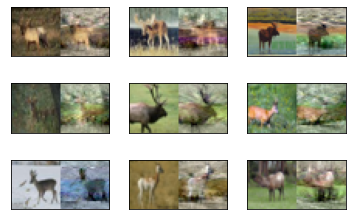

In [0]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((np.clip(x_train_airplane1[idx], 0, 1), np.clip(X_train_corrupt[idx], 0, 1)), 1)
    axes[row,col].imshow(im)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss',patience=2)

model.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model.fit(X_train_corrupt, x_train_airplane1, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopper])

Epoch 1/50
125/125 [==============================] - 4s 32ms/step - loss: 0.1857 - mae: 0.1857 - val_loss: 0.1421 - val_mae: 0.1421
Epoch 2/50
125/125 [==============================] - 4s 28ms/step - loss: 0.1389 - mae: 0.1389 - val_loss: 0.1449 - val_mae: 0.1449
Epoch 3/50
125/125 [==============================] - 4s 28ms/step - loss: 0.1331 - mae: 0.1331 - val_loss: 0.1306 - val_mae: 0.1306
Epoch 4/50
125/125 [==============================] - 4s 28ms/step - loss: 0.1300 - mae: 0.1300 - val_loss: 0.1278 - val_mae: 0.1278
Epoch 5/50
125/125 [==============================] - 4s 28ms/step - loss: 0.1274 - mae: 0.1274 - val_loss: 0.1247 - val_mae: 0.1247
Epoch 6/50
125/125 [==============================] - 4s 28ms/step - loss: 0.1241 - mae: 0.1241 - val_loss: 0.1242 - val_mae: 0.1242
Epoch 7/50
125/125 [==============================] - 4s 28ms/step - loss: 0.1213 - mae: 0.1213 - val_loss: 0.1263 - val_mae: 0.1263
Epoch 8/50
125/125 [==============================] - 4s 28ms/step - 

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
augmentation_gen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

x_train_airplane_tr = x_train_airplane1[0:4000]
x_train_airplane_va = x_train_airplane1[4000:5000]
for i in range(0,9):
  train_gen = augmentation_gen.flow(x_train_airplane1, batch_size=5000,shuffle=False) 
  temp = train_gen[0]
  x_train_airplane_tr = np.concatenate((x_train_airplane_tr,temp[0:4000]))
  x_train_airplane_va = np.concatenate((x_train_airplane_va,temp[4000:5000]))

del temp
print('New training data shape: {}'.format(x_train_airplane_tr.shape))
print('New validating data shape: {}'.format(x_train_airplane_va.shape))

New training data shape: (40000, 32, 32, 3)
New validating data shape: (10000, 32, 32, 3)


In [0]:
x_train_airplane1 = np.concatenate((x_train_airplane_tr,x_train_airplane_va))
del x_train_airplane_tr
del x_train_airplane_va

In [0]:
print('New training data shape: {}'.format(x_train_airplane1.shape))

New training data shape: (50000, 32, 32, 3)


In [0]:
X_train_mag,X_train_phase = pre_process_mag(x_train_airplane1)
X_test_mag,X_test_phase = pre_process_mag(x_test_airplane1)


In [0]:
X_train_corrupt, magx = reconstructAllX2A(X_train_mag,X_train_phase)
del X_train_mag
del X_train_phase
X_test_corrupt = reconstructAllX2B(X_test_mag,X_test_phase, magx)
del X_test_mag
del X_test_phase

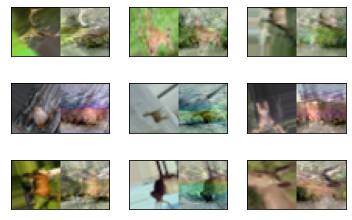

In [0]:
import matplotlib.pyplot as plt

N=3
start_val = 5000# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((np.clip(x_train_airplane1[idx], 0, 1), np.clip(X_train_corrupt[idx], 0, 1)), 1)
    axes[row,col].imshow(im)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss',patience=2)

model.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model.fit(X_train_corrupt, x_train_airplane1, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopper])

Epoch 1/50
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1701 - mae: 0.1701 - val_loss: 0.1225 - val_mae: 0.1225
Epoch 2/50
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1196 - mae: 0.1196 - val_loss: 0.1168 - val_mae: 0.1168
Epoch 3/50
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1149 - mae: 0.1149 - val_loss: 0.1133 - val_mae: 0.1133
Epoch 4/50
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1121 - mae: 0.1121 - val_loss: 0.1116 - val_mae: 0.1116
Epoch 5/50
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1099 - mae: 0.1099 - val_loss: 0.1132 - val_mae: 0.1132
Epoch 6/50
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1079 - mae: 0.1079 - val_loss: 0.1116 - val_mae: 0.1116


In [0]:
score = model.evaluate(X_test_corrupt, x_test_airplane1, verbose=0)

print(score)

[0.11256732791662216, 0.11256732791662216]


In [0]:
pred = model.predict(X_train_corrupt)

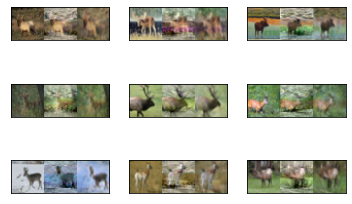

In [0]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_train_airplane1[idx],0,1),np.clip(X_train_corrupt[idx],0,1)))
    se2 =  np.hstack((se, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
pred = model.predict(X_test_corrupt)

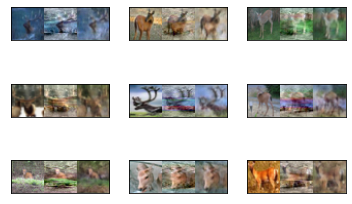

In [0]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_test_airplane1[idx],0,1),np.clip(X_test_corrupt[idx],0,1)))
    se2 =  np.hstack((se, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
del pred

In [0]:
X_train_corrupt2 = model.predict(X_train_corrupt)
X_test_corrupt2 = model.predict(X_test_corrupt)

In [0]:
X_train_mag,X_train_phase = pre_process_mag(X_train_corrupt2)  # get mag from prediction
del X_train_phase
X_train_magx,X_train_phase = pre_process_mag(x_train_airplane1)   #get phase from data
del X_train_magx
X_train_corrupt3 = reconstructAll(X_train_mag, X_train_phase)  #combine
del X_train_mag
del X_train_phase

X_test_mag,X_test_phase = pre_process_mag(X_test_corrupt2)
del X_test_phase
X_test_magx,X_test_phase = pre_process_mag(x_test_airplane1)
del X_test_magx
X_test_corrupt3 = reconstructAll(X_test_mag, X_test_phase)
del X_test_mag
del X_test_phase

#del X_train_corrupt2

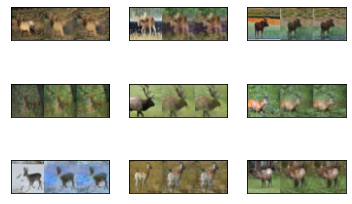

In [0]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_train_airplane1[idx],0,1),np.clip(X_train_corrupt2[idx],0,1)))
    se2 =  np.hstack((se, np.clip(X_train_corrupt3[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

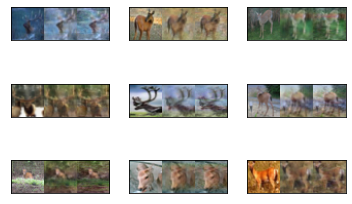

In [0]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_test_airplane1[idx],0,1),np.clip(X_test_corrupt2[idx],0,1)))
    se2 =  np.hstack((se, np.clip(X_test_corrupt3[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
from sklearn.metrics import mean_absolute_error

print(x_test_airplane1.shape)

mae = (np.sum(np.absolute((x_test_airplane1 - X_test_corrupt3))))/(1000*32*32*3)

print(mae)

(1000, 32, 32, 3)
0.11013896718882175


In [0]:
del X_train_corrupt


In [0]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss',patience=2)

model2.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model2.fit(X_train_corrupt3, x_train_airplane1, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopper])

Epoch 1/50
1250/1250 [==============================] - 36s 28ms/step - loss: 0.1153 - mae: 0.1153 - val_loss: 0.1060 - val_mae: 0.1060
Epoch 2/50
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1004 - mae: 0.1004 - val_loss: 0.1051 - val_mae: 0.1051
Epoch 3/50
1250/1250 [==============================] - 35s 28ms/step - loss: 0.0996 - mae: 0.0996 - val_loss: 0.1048 - val_mae: 0.1048
Epoch 4/50
1250/1250 [==============================] - 35s 28ms/step - loss: 0.0990 - mae: 0.0990 - val_loss: 0.1037 - val_mae: 0.1037
Epoch 5/50
1250/1250 [==============================] - 35s 28ms/step - loss: 0.0982 - mae: 0.0982 - val_loss: 0.1029 - val_mae: 0.1029
Epoch 6/50
1250/1250 [==============================] - 35s 28ms/step - loss: 0.0976 - mae: 0.0976 - val_loss: 0.1026 - val_mae: 0.1026
Epoch 7/50
1250/1250 [==============================] - 35s 28ms/step - loss: 0.0969 - mae: 0.0969 - val_loss: 0.1030 - val_mae: 0.1030
Epoch 8/50
1250/1250 [==========================

In [0]:
score = model2.evaluate(X_test_corrupt3, x_test_airplane1, verbose=0)

print(score)

[0.1067773699760437, 0.1067773699760437]


In [0]:
pred = model2.predict(X_train_corrupt3)

In [0]:
import matplotlib.pyplot as plt

N=2
start_val = 10# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_train_airplane1[idx],0,1),np.clip(X_train_corrupt[idx],0,1)))
    se2 =  np.hstack((se, np.clip(X_train_corrupt2[idx],0,1)))
    se3 =  np.hstack((se2, np.clip(X_train_corrupt3[idx],0,1)))
    se4 =  np.hstack((se3, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se4)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
del x_train_airplane1
del X_train_corrupt3
pred = model2.predict(X_test_corrupt3)

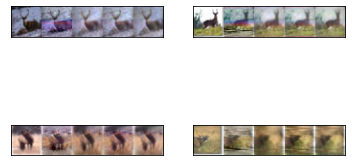

In [0]:
import matplotlib.pyplot as plt

N=2
start_val = 25# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_test_airplane1[idx],0,1),np.clip(X_test_corrupt[idx],0,1)))
    se2 =  np.hstack((se, np.clip(X_test_corrupt2[idx],0,1)))
    se3 =  np.hstack((se2, np.clip(X_test_corrupt3[idx],0,1)))
    se4 =  np.hstack((se3, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se4)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])